### This notebook is dedicated to evaluating the TWSA trends of GEACE/GRACE-FO obtained from different methods.
Author: S. Karimi Feb 2024 (s.karimi@utwente.nl)

# Read data

In [1]:
import xarray as xr
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
data_dir= "output"
twsa_netcdf= 'twsa_nileregion.nc'
fullpath= os.path.join(data_dir, twsa_netcdf)
print(fullpath)

output/twsa_nileregion.nc


In [3]:
ds = xr.open_dataset(fullpath) # load TWSA of Nile watershed obtained from grid-tws-finalversion 

In [4]:
import geopandas as gpd

geopackage_path = 'global-gis/nile.gpkg'

gdf = gpd.read_file(geopackage_path)

In [33]:
#area = gdf.area_calc
ss= area*100000
ss

0    3.078088e+11
Name: area_calc, dtype: float64

gdf.area_calc.values
area = gdf.area_calc.values * (10 ** 6)
area

In [36]:
scale = gdf.area_calc/sec
scale

0    1.187534
Name: area_calc, dtype: float64

# Time derivatives of TWS anomalies

As an example, the computations are applied to the TWSA obtained from the filtered version of GRACE/GRACE-FO observations using the DDK5 filter. It is also possible to apply these steps to both unfiltered data and data filtered using the Gaussian filter.

# Bspline smoothing

We create an approximation of the TWSA time series from GRCAE/GRACE-FO using the Bspline smoothing method. The advantage of this method is that it does not require passing from all data points of GRACE and GRACE_FO observations, which are noisy.

The approximated version is indicated for GRACE-FO time series.

In [5]:
from scipy.interpolate import splrep, BSpline # source: https://docs.scipy.org/doc/scipy/tutorial/interpolate/smoothing_splines.html

In [6]:
time_bs = ds['time'].values
time_integer_bs = (time_bs - time_bs[0]) / np.timedelta64(1, 's')


In [7]:
smoothing_level= len(ds['time'])
display(smoothing_level)

191

in each Bspline basis function: Ni,k(u)
K = degree
u = total number of of knots in the knot verctor
i = index of a specific knot in the knot verctor
n = number of data points (control points)
is the smoothing level = 0. Then, the number of knots are:
Knots = n + k + 1
K= 0 , Ni,0 represents the zero degree (piecewise constant) Bspline basis function
K = 1, Ni,1 represents the first-degree (linear) B-spline basis function.
k =2, Ni,2 represents the second-degree (quadratic) Bspline basis function.
K = 3, Ni,3 represents the third-degree (cubic) Bspline function.
K =3 Then we have 12 basis functions.

Number of coeffcients related to the degree = u - k -1 = control points

In [60]:
#smoothing_level= len(ds['time'])


tck = splrep(time_integer_bs, ds.ddk, k=3, s = smoothing_level)

#tck = splrep(time_integer_bs, ds.ddk, k=3, s = smoothing_level*0.0005)

# Extracting knots, coefficients, and degree from tck
knots, coefficients, degree = tck


# Creating a Bspline object with BSpline class 
bspline = BSpline(knots, coefficients, degree)

#time_new = np.linspace(time_month.min(), time_month.max(), 200)
#ddk_new = bspline(time_new)

ds_ddk_bs = bspline(time_integer_bs)
time_integer_bs

array([0.000000e+00, 1.987200e+06, 1.045440e+07, 1.308960e+07,
       1.572480e+07, 1.836000e+07, 2.099520e+07, 2.367360e+07,
       2.622240e+07, 2.877120e+07, 3.140640e+07, 3.360960e+07,
       3.931200e+07, 4.199040e+07, 4.462560e+07, 4.721760e+07,
       4.989600e+07, 5.253120e+07, 5.443200e+07, 5.793120e+07,
       6.039360e+07, 6.302880e+07, 6.566400e+07, 6.829920e+07,
       8.151840e+07, 8.415360e+07, 8.683200e+07, 8.938080e+07,
       9.192960e+07, 9.456480e+07, 9.720000e+07, 9.983520e+07,
       1.024704e+08, 1.051488e+08, 1.077840e+08, 1.104192e+08,
       1.130544e+08, 1.156896e+08, 1.183680e+08, 1.209168e+08,
       1.234656e+08, 1.261008e+08, 1.287360e+08, 1.313712e+08,
       1.340064e+08, 1.366848e+08, 1.393200e+08, 1.419552e+08,
       1.445904e+08, 1.472256e+08, 1.499040e+08, 1.524528e+08,
       1.550016e+08, 1.576368e+08, 1.602720e+08, 1.629072e+08,
       1.655424e+08, 1.682208e+08, 1.708560e+08, 1.734912e+08,
       1.761264e+08, 1.787616e+08, 1.814400e+08, 1.8403

In [9]:
bspline_dr=bspline.derivative()
dsdt_timederivative= bspline_dr(time_integer_bs)

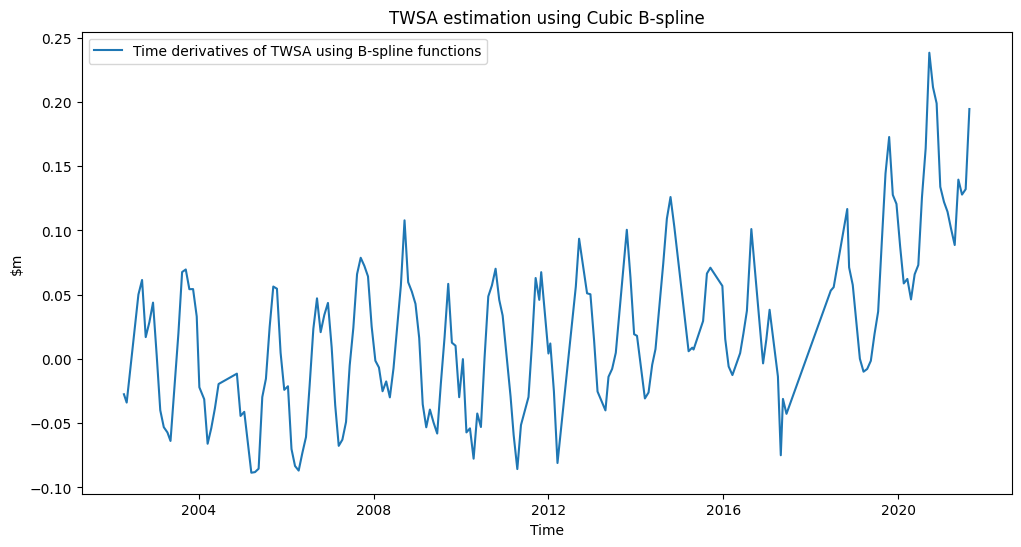

In [10]:
plt.figure(figsize=(12, 6))
#plt.plot(ds['time'], ds.ddk* area, 'r-', label='TWSA')
plt.plot(ds['time'], ds.ddk, '-', label='Time derivatives of TWSA using B-spline functions')
#plt.plot(ds['time'], dsdt_timederivative, '-', label='Time derivatives of TWSA using B-spline functions')

plt.legend()
plt.xlabel('Time')
plt.ylabel('$m')
plt.title('TWSA estimation using Cubic B-spline')
plt.show()

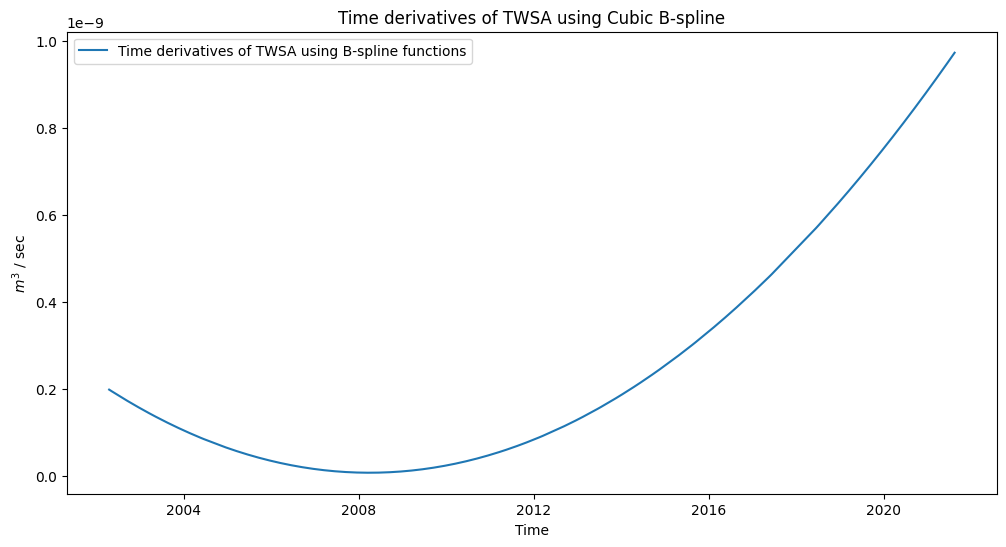

In [11]:
#time_new_datetime = np.array([np.datetime64('2002-04') + np.timedelta64(int(m), 'M') for m in time_new])

# Plotting
plt.figure(figsize=(12, 6))
#plt.plot(ds['time'], ddk, 'r-', label='TWSA')
#plt.plot(ds['time'], dsdt_m3_sec_ddk, '-', label='Time derivatives of TWSA using B-spline functions')
plt.plot(ds['time'], dsdt_timederivative, '-', label='Time derivatives of TWSA using B-spline functions')

plt.legend()
plt.xlabel('Time')
plt.ylabel('$m^3$ / sec')
plt.title('Time derivatives of TWSA using Cubic B-spline')
plt.show()


In [37]:
area = gdf.area_calc.values * (10 ** 6)

sec = 30 * 3600 * 24


scale = area / sec


dsdt_timederivative_scale = dsdt_timederivative * scale
 


#ds_volume_ddk = ds.ddk* area / sec

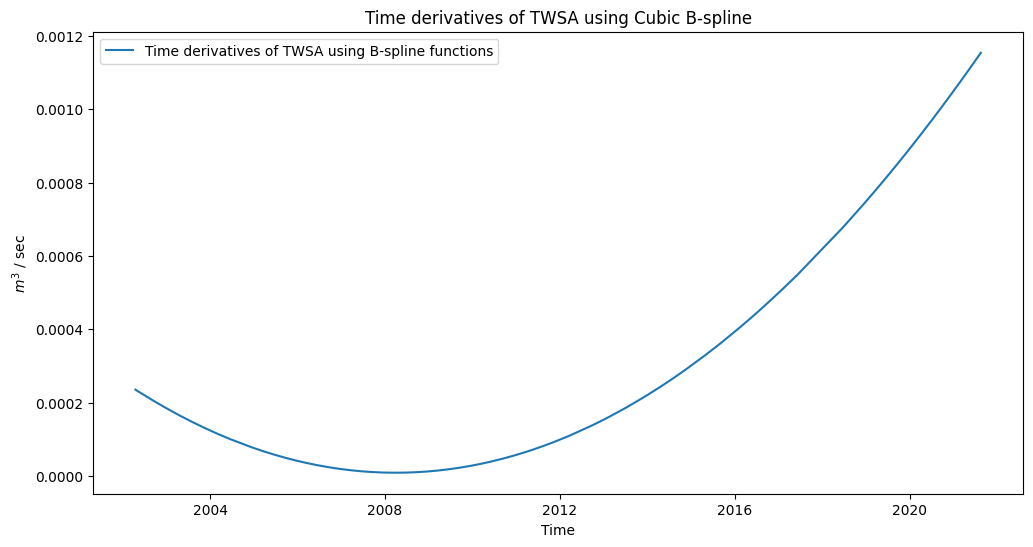

In [39]:
plt.figure(figsize=(12, 6))
#plt.plot(ds['time'], ddk, 'r-', label='TWSA')
#plt.plot(ds['time'], dsdt_m3_sec_ddk, '-', label='Time derivatives of TWSA using B-spline functions')
plt.plot(ds['time'], dsdt_timederivative_scale, '-', label='Time derivatives of TWSA using B-spline functions')

plt.legend()
plt.xlabel('Time')
plt.ylabel('$m^3$ / sec')
plt.title('Time derivatives of TWSA using Cubic B-spline')
plt.show()


Next: remove annual variations to only have inter annual variations before applying the bspline
method: ls will fit cosin and sin functions- read relevant articles
change the unit to later compare with other models
all steps should be applied before bspline modeling


# Comparing with other methods

# Backwards difference approximation

In [41]:
def calculate_ds(TWS, delta_t):
    
    
        #for i in range(1, len(TWS.time) - 1):
        #cntws = (TWS.isel(time=i+1) - TWS.isel(time=i-1)) / (2 * delta_t)
       # cntws_values.append(cntws)

    TWS_diff = TWS.diff(dim='time') / delta_t
    time_values = TWS.time[1:]
    #diff.append(TWS_diff)

    return TWS_diff,time_values



In [42]:
delta_t = 1  

#middle_times = calculate_time(ds, delta_t)

ds_ddk_bw, time_values= calculate_ds(ds.ddk, delta_t)
#ds_m3_sec_ddk


#dsdt = xr.DataArray(diffi, coords={'time': middle_times}, dims=['time'])

dsdt_backward_differences = xr.Dataset({'ds_ddk_bw': (('time',), ds_ddk_bw.values)}, coords={'time_bw': time_values.values})


# Centred differences approximation

In [43]:
def centered_tws(TWS, delta_t):
    cntws_values = []
    for i in range(1, len(TWS.time) - 1):
        cntws = (TWS.isel(time=i+1) - TWS.isel(time=i-1)) / (2 * delta_t)
        cntws_values.append(cntws)
        
    #time_values = xr.concat(cntws_values, dim='time')
    #time_values1 = time_values.assign_coords(time=ds.tws.time[1:-1].values)
    time_values = TWS.time[1:-1]
   
    return cntws_values, time_values

In [44]:
delta_t = 1
ds_tws1,time_values= centered_tws(ds.ddk, delta_t)

#ds_m3_sec_ddk

#ds_ddk1,time_values= centered_tws(ds.ddk, delta_t)


dsdt_centered_differences = xr.Dataset({'ds_ddk_cd': (('time',), ds_tws1)}, coords={'time_cd': time_values.values})


#ds_tws2 = xr.DataArray(Vads_tws1, dims='time', coords={'time': time_values})

In [45]:
dsdt_centered_differences

<xarray.Dataset>
Dimensions:    (time: 189, time_cd: 189)
Coordinates:
  * time_cd    (time_cd) datetime64[ns] 2002-05-10T11:59:59.500000 ... 2021-0...
Dimensions without coordinates: time
Data variables:
    ds_ddk_cd  (time) float64 0.03878 0.04769 -0.01656 ... -0.003725 0.03329

# Comparing three methods 

In [51]:
dsdt_centered_differences_scaled= dsdt_centered_differences*scale
dsdt_backward_differences_scaled= dsdt_backward_differences*scale

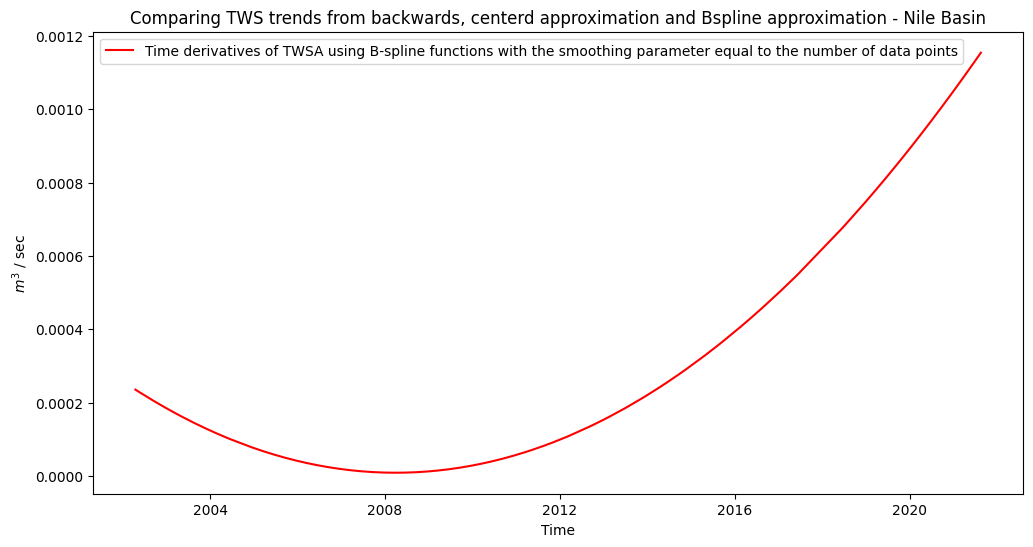

In [59]:
plt.figure(figsize=(12,6))
#plt.plot(dsdt_backward_differences['time_bw'],dsdt_backward_differences_scaled ['ds_ddk_bw'],'b-',label='Time derivatives of TWSA time series using backward differences method')
#plt.plot(dsdt_centered_differences['time_cd'],dsdt_centered_differences_scaled ['ds_ddk_cd'],'g-',label='Time derivatives of TWSA time series using centered differences method')
#plt.plot(ds['time'], dsdt_m3_sec_ddk,  'r-', label='Cubic B-spline approximation of TWSA from GRACE-FO with the smoothing parameter equal to the number of data points')
plt.plot(ds['time'], dsdt_timederivative_scale,  'r-', label='Time derivatives of TWSA using B-spline functions with the smoothing parameter equal to the number of data points')

plt.xlabel('Time')
plt.ylabel('$m^3$ / sec')
plt.title('Comparing TWS trends from backwards, centerd approximation and Bspline approximation - Nile Basin')
plt.legend(loc='best')
#plt.xticks(rotation=45)

plt.show()

# Conclusion

The Centered method results in a smoother rate than the backward method. However, both backwards and centered differences methods do not indicate the effect of the significant increase in TWSA from 2019 to 2021 in the TWSA time series obtained from GRACE-FO observations. This limitation can be due to high noise levels present in GRACE/GRACE-FO observations after filtering, which indicates that a higher level of smoothing is still required. 

In contrast, the Bspline method yields a smoother, more robust, and less noisy signal.

As a result, it is recommended to approximate the TWSA time series using cubic B-spline functions.